##Deep Lab v3

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("soumikrakshit/nyu-depth-v2")

print("Path to dataset files:", path)

100%|██████████| 4.10G/4.10G [03:32<00:00, 20.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1


In [ ]:
!pip install torch torchvision torchaudio
!pip install segmentation-models-pytorch
!pip install albumentations
!pip install opencv-python
!pip install torchmetrics
!pip install scikit-learn
!pip install tqdm
!pip install matplotlib
!pip install Pillow
!pip install pandas


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
from pathlib import Path

# Setting paths
train_csv = Path('/root/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('/root/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train')
base_path = Path('/root/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data')

print("Train CSV Path:", train_csv)
print("Train Images Path:", train_ims_path)
print("Base Path:", base_path)


Train CSV Path: /root/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv
Train Images Path: /root/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train
Base Path: /root/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data


In [ ]:
df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

0  \
0  /root/.cache/kagglehub/datasets/soumikrakshit/...   
1  /root/.cache/kagglehub/datasets/soumikrakshit/...   
2  /root/.cache/kagglehub/datasets/soumikrakshit/...   
3  /root/.cache/kagglehub/datasets/soumikrakshit/...   
4  /root/.cache/kagglehub/datasets/soumikrakshit/...   

                                                   1  
0  /root/.cache/kagglehub/datasets/soumikrakshit/...  
1  /root/.cache/kagglehub/datasets/soumikrakshit/...  
2  /root/.cache/kagglehub/datasets/soumikrakshit/...  
3  /root/.cache/kagglehub/datasets/soumikrakshit/...  
4  /root/.cache/kagglehub/datasets/soumikrakshit/...

In [ ]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(45619, 4562, 507)

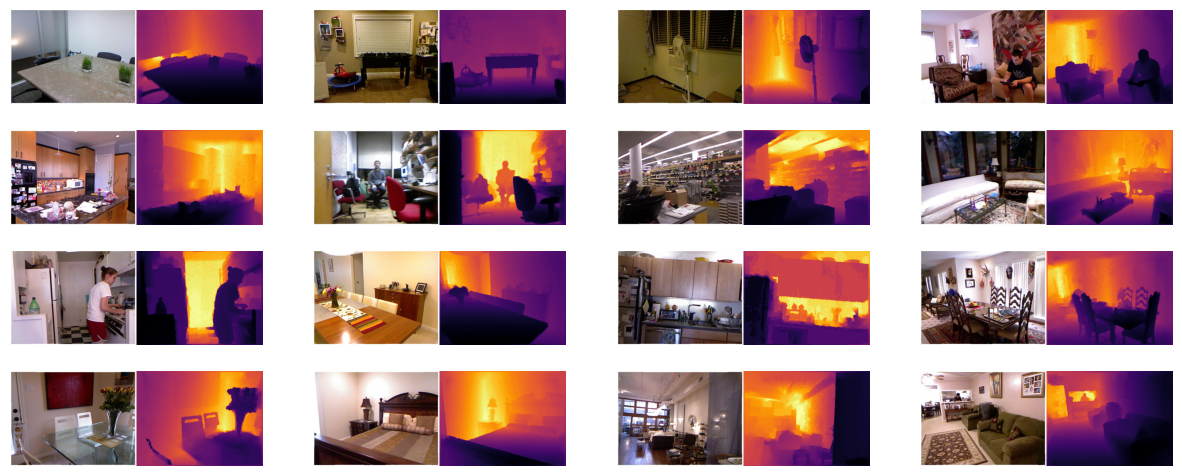

In [ ]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])

    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [ ]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384,384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [ ]:
class Dataset:
    def __init__(self,df,tfms):
        self.df = df
        self.tfms=tfms
    def open_im(self,p,gray=False):
        im = cv.imread(str(p))
        im = cv.cvtColor(im,cv.COLOR_BGR2GRAY if gray else cv.COLOR_BGR2RGB)
        return im

    def __len__(self,):
        return len(self.df)

    def __getitem__(self,idx):
        s = self.df.iloc[idx,:]
        im, dp = s[0],s[1]
        im, dp = self.open_im(im), self.open_im(dp,True)
        augs = self.tfms(image=im,mask=dp)
        im, dp = augs['image'], augs['mask'] / 255.
        return im, dp.unsqueeze(0)

In [ ]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(45619, 4562, 507)

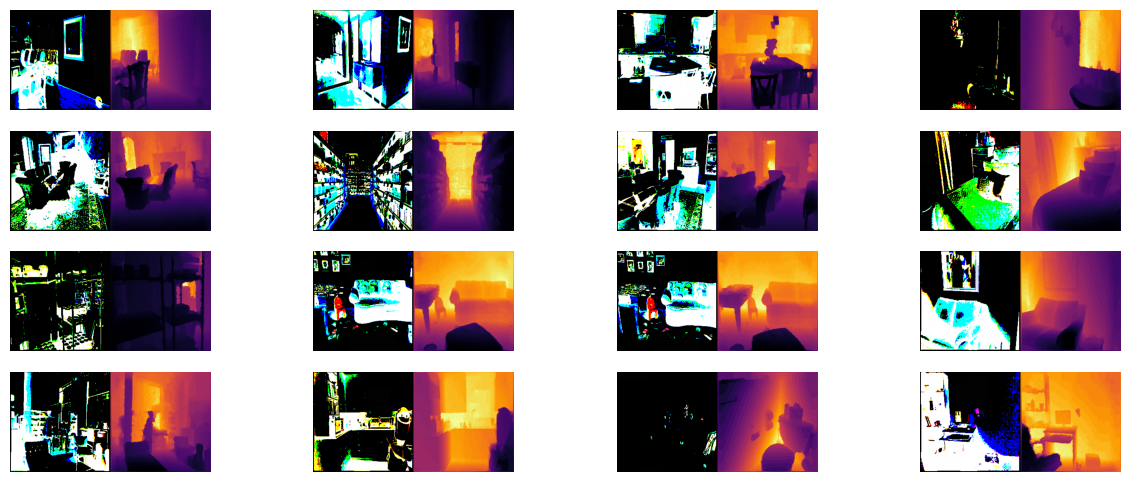

In [ ]:
randoms = [test_ds[idx] for idx in range(16)]
plt.figure(figsize=(15, 6))
for i, (img,mask) in enumerate(randoms):
    ax = plt.subplot(4, 4, i + 1)
    img, mask = img.permute(1,2,0).numpy(), mask.permute(1,2,0).numpy()
    mask = colored_depthmap(np.squeeze(mask))
    image_viz = np.hstack([img,mask])
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

In [ ]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(713, 72, 127)

In [ ]:
import segmentation_models_pytorch as smp

class DeepLabV3Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = smp.DeepLabV3(
            encoder_name='resnext50_32x4d',
            in_channels=3,
            classes=1
        )

    def trainable_encoder(self, trainable=True):
        for p in self.model.encoder.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

    def _num_params(self):
        return sum([p.numel() for p in self.model.parameters() if p.requires_grad])


In [ ]:
class UnNormalize(Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/prediction/target' if len(title)!=0 else 'image/prediction/target'
    plt.suptitle(title)
    plt.show()

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://download.pytorch.org/whl/cu117


In [ ]:
!nvidia-smi

Fri Sep 27 18:15:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

print(torch.cuda.is_available())

print(torch.version.cuda)

print(torch.cuda.get_device_name(0))


True
12.1
Tesla T4


In [ ]:
# Install PyTorch with CUDA support
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [ ]:
# Import necessary modules
from torch.optim import AdamW
from torch.nn import MSELoss
from torch.optim.lr_scheduler import OneCycleLR
from torch.amp import GradScaler  # Corrected import for GradScaler
from torchmetrics import MetricCollection, MeanSquaredError
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM

# Epochs and learning rate setup
epochs = 10
freeze_epochs = 2
lr = 1e-3

# Use CUDA
device = 'cuda'

# Set up metrics
metrics = MetricCollection([
    SSIM(data_range=(0,1)),
    MeanSquaredError()
]).to(device)
train_metrics = metrics.clone()
val_metrics = metrics.clone()

# Create logs DataFrame
logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val']] = None

# Model setup
model = DeepLabV3Model().to(device)
model.trainable_encoder(trainable=False)

# Loss function, optimizer, and scheduler setup
loss_fn = MSELoss()
optim = AdamW(model.parameters(), lr=lr / 25., weight_decay=0.02)
sched = OneCycleLR(optim, max_lr=lr, epochs=epochs, steps_per_epoch=len(train_dl))

# Gradient scaler (corrected usage)
scaler = GradScaler()  # No need for the 'cuda' argument anymore, it works with the current device


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 107MB/s]


training decoder only


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
0    0.02826  0.010806   0.624561  0.801525  0.028265  0.010819




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


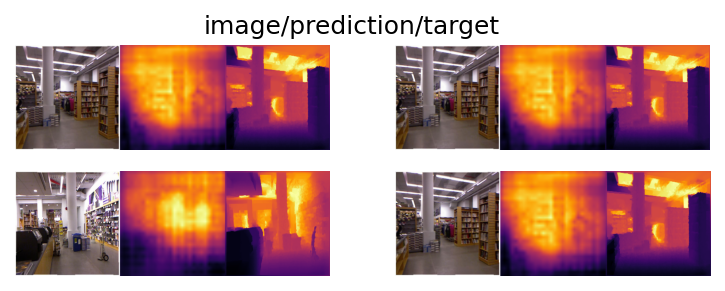

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
1   0.012725  0.008508   0.803089  0.825561  0.012726  0.008522




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


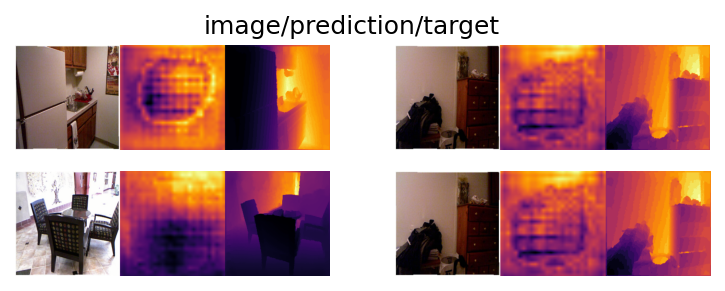

training encoder and decoder both


  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train loss_val ssim_train  ssim_val mse_train   mse_val
2   0.012478   0.0071   0.821852  0.828039  0.012478  0.007097




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


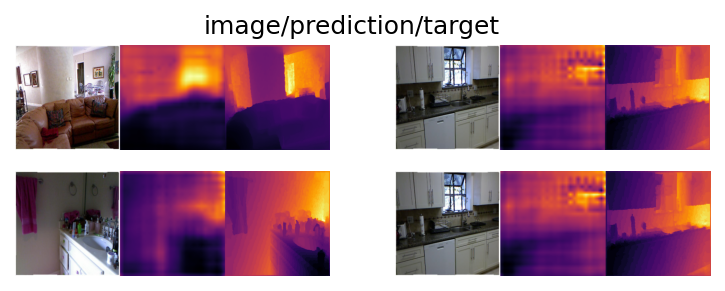

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
3   0.009375  0.005284   0.833534  0.842899  0.009375  0.005285




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


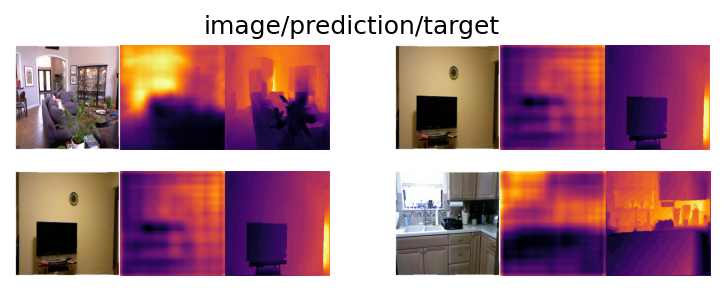

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
4    0.00808  0.004311   0.838253  0.849804  0.008081  0.004318




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


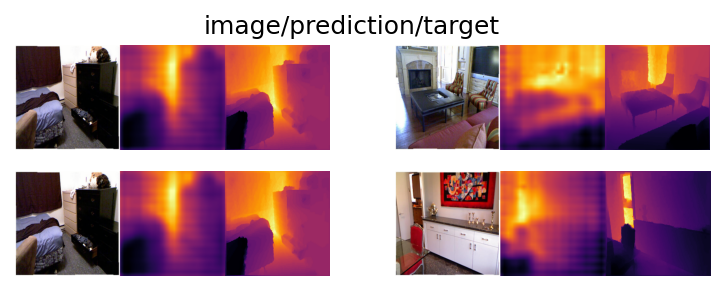

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train ssim_val mse_train   mse_val
5   0.006897  0.005016    0.84297  0.85726  0.006897  0.005026




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


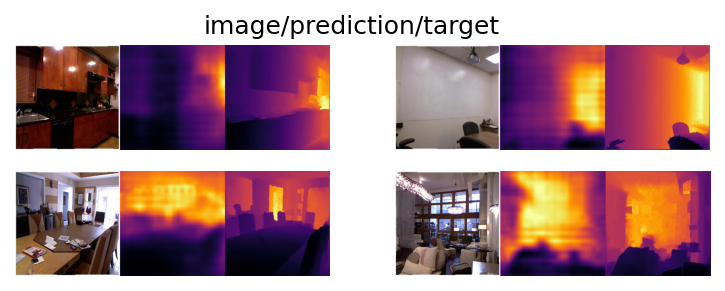

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train loss_val ssim_train  ssim_val mse_train   mse_val
6   0.005878  0.00336   0.847306  0.861918  0.005878  0.003366




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


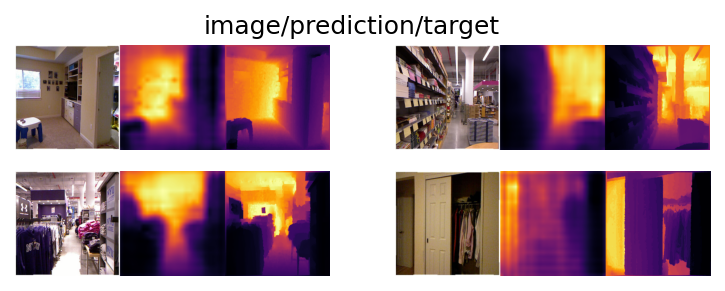

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
7   0.004862  0.002717   0.851359  0.862904  0.004862  0.002719




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


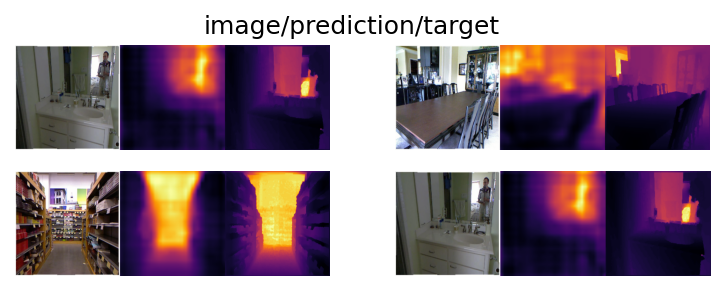

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
8    0.00406  0.002314   0.854606  0.864556   0.00406  0.002319




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


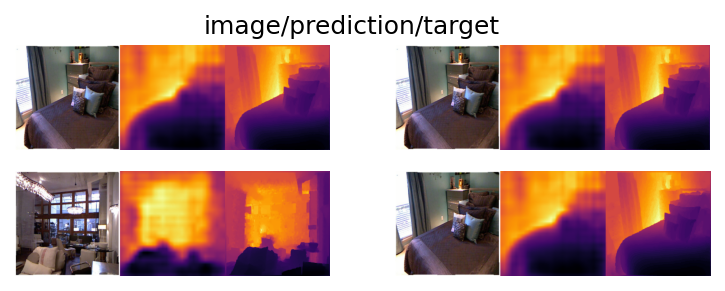

  0%|          | 0/713 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


  0%|          | 0/72 [00:00<?, ?it/s]

<ipython-input-23-298c1479217e>:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():




  loss_train  loss_val ssim_train  ssim_val mse_train   mse_val
9   0.003806  0.002314   0.855777  0.864915  0.003806  0.002319




<ipython-input-23-298c1479217e>:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


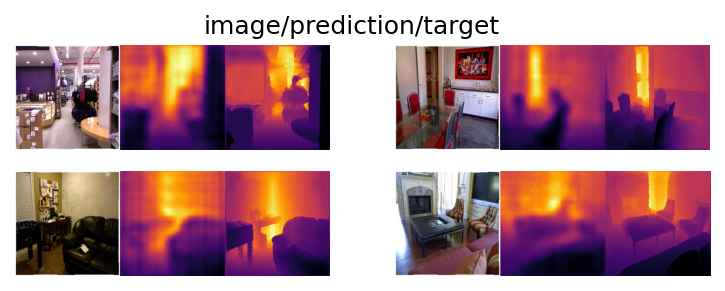

In [ ]:
best_ssim = -1e9
best_epoch = -1

print('training decoder only')

for epoch in tqdm(range(epochs)):

    model.train()

    if epoch == freeze_epochs:
        model.trainable_encoder(trainable=True)
        print('training encoder and decoder both')

    running_loss = 0.
    train_prog = tqdm(train_dl,total=len(train_dl))

    for img, mask in train_prog:

        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)

            loss = loss_fn(preds,mask)
            scaler.scale(loss).backward()
            scaler.unscale_(optim)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
            scaler.step(optim)
            scaler.update()
            sched.step()
            optim.zero_grad()

            running_loss += loss.item()

            train_prog.set_description(f'loss: {loss.item():.3f}')
            train_metrics(preds,mask)

        del img, mask, preds, loss

    m = train_metrics.compute()
    _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
    logs.loc[epoch,['loss_train','ssim_train','mse_train']] = (running_loss/len(train_dl),_ssim,_mse)
    train_metrics.reset()
    model.eval()

    with torch.no_grad():

        running_loss = 0.

        val_prog = tqdm(val_dl,total=len(val_dl))
        for img, mask in val_prog:

            with autocast():
                img, mask = img.to(device), mask.to(device)
                preds = model(img)
                loss = loss_fn(preds,mask)
                running_loss += loss.item()
                val_prog.set_description(f'loss: {loss.item():.3f}')

                val_metrics(preds, mask)

            del img, mask, preds, loss

        m = val_metrics.compute()
        _ssim,_mse = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item()
        logs.loc[epoch,['loss_val','ssim_val','mse_val']] = (running_loss/len(val_dl),_ssim,_mse)
        val_metrics.reset()

    if _ssim > best_ssim:
        best_ssim = _ssim
        best_epoch = epoch
        sd = model.state_dict()
        torch.save(sd,'nyu-v2-depth-resnext50_32x4d-unetplusplus.pt')

    print(f"\n\n{logs.tail(1)}\n\n")

    with torch.no_grad():
        with autocast():
            img, mask = next(iter(test_dl))
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            plot_vals(
                img.cpu(),
                preds.cpu(),
                mask.cpu()
            )

    gc.collect()
    torch.cuda.empty_cache()


Evaluating on the test set...



  0%|          | 0/127 [00:00<?, ?it/s]

<ipython-input-24-c4bfcda7fa08>:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Test Loss: 0.0026
Test SSIM: 0.8584
Test MSE: 0.0026

Visualizing results from the test set...



<ipython-input-24-c4bfcda7fa08>:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


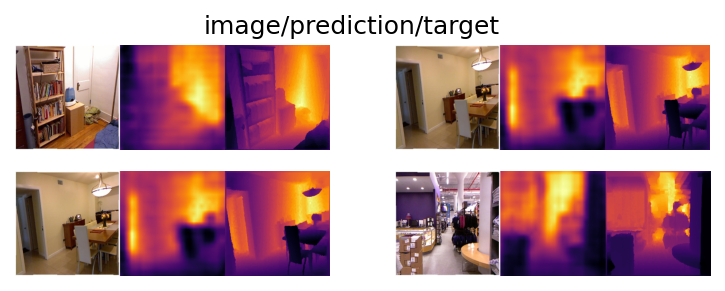


Training logs saved to 'training_logs.csv'.


Final model saved to 'nyu-v2-depth-final.pt'.


Training Summary:
Best SSIM: 0.8649 achieved at epoch 9.
Final Test SSIM: 0.8584
Final Test MSE: 0.0026


In [ ]:
# Final evaluation on the test set
print("\nEvaluating on the test set...\n")
test_metrics = metrics.clone().to(device)

model.eval()
with torch.no_grad():
    running_loss = 0.
    test_prog = tqdm(test_dl, total=len(test_dl))

    for img, mask in test_prog:
        with autocast():
            img, mask = img.to(device), mask.to(device)
            preds = model(img)
            loss = loss_fn(preds, mask)
            running_loss += loss.item()
            test_prog.set_description(f'loss: {loss.item():.3f}')

            # Compute test metrics
            test_metrics(preds, mask)

        del img, mask, preds, loss

    # Compute final test metrics
    test_results = test_metrics.compute()
    ssim_test = test_results['StructuralSimilarityIndexMeasure'].cpu().item()
    mse_test = test_results['MeanSquaredError'].cpu().item()
    test_metrics.reset()

    print(f"\nTest Loss: {running_loss / len(test_dl):.4f}")
    print(f"Test SSIM: {ssim_test:.4f}")
    print(f"Test MSE: {mse_test:.4f}")

# Visualize results from the test set
print("\nVisualizing results from the test set...\n")
with torch.no_grad():
    with autocast():
        img, mask = next(iter(test_dl))
        img, mask = img.to(device), mask.to(device)
        preds = model(img)

        # Plot a subset of images
        plot_vals(
            img.cpu(),
            preds.cpu(),
            mask.cpu()
        )

# Save logs to a file
logs.to_csv('training_logs.csv', index=False)
print(f"\nTraining logs saved to 'training_logs.csv'.\n")

# Save final model
final_model_path = 'nyu-v2-depth-final.pt'
torch.save(model.state_dict(), final_model_path)
print(f"\nFinal model saved to '{final_model_path}'.\n")

# Summary of training
print("\nTraining Summary:")
print(f"Best SSIM: {best_ssim:.4f} achieved at epoch {best_epoch}.")
print(f"Final Test SSIM: {ssim_test:.4f}")
print(f"Final Test MSE: {mse_test:.4f}")


In [ ]:
# Import necessary libraries
from google.colab import files

# Save logs to a file
logs.to_csv('training_logs1.csv', index=False)
print(f"\nTraining logs saved to 'training_logs.csv'.\n")

# Enable file download for training logs
files.download('training_logs1.csv')  # This will trigger the download of the CSV file

# Save final model
final_model_path = 'nyu-v2-depth-final1.pt'
torch.save(model.state_dict(), final_model_path)
print(f"\nFinal model saved to '{final_model_path}'.\n")

# Enable file download for the model
files.download(final_model_path)  # This will trigger the download of the model file



Training logs saved to 'training_logs.csv'.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Final model saved to 'nyu-v2-depth-final1.pt'.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

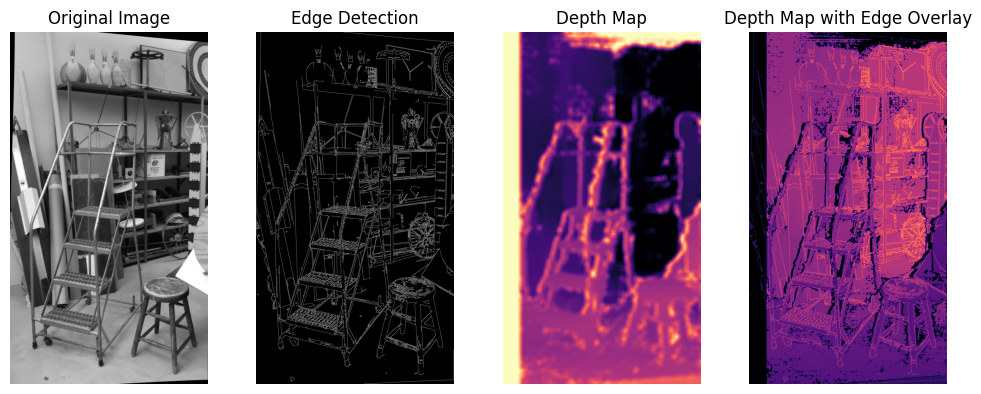

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image
from torch.cuda.amp import autocast
from torchvision.models.segmentation import deeplabv3_resnet50 as DeepLabV3

# Define the model class (DeepLabV3 for depth prediction)
class DeepLabV3Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = DeepLabV3(
            encoder_name='resnext50_32x4d',
            in_channels=3,
            classes=1
        )

    def forward(self, x):
        return self.model(x)

# Load the saved model
model_path = "/content/nyu-v2-depth-final.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DeepLabV3Model().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Step 1: Preprocessing the image
def preprocess_image(image_path):
    """
    Preprocess the image by resizing, normalizing, and converting to tensor.
    Loads the image in grayscale and replicates channels.
    """
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel grayscale
        transforms.ToTensor(),                      # Convert image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
    ])
    image = Image.open(image_path).convert('L')   # Load image as grayscale
    image = transform(image).unsqueeze(0)         # Add batch dimension
    return image

# Load and preprocess a sample image
image_path = "/content/im0.png"  # Replace with the actual path
img = preprocess_image(image_path).to(device)

# Step 2: Evaluate and Process Depth Maps using DeepLabV3
with torch.no_grad():
    # Predict depth using the loaded model
    with autocast():
        preds = model(img)  # Predicted depth map

    # Get depth map and normalize it
    pred_depth_map = preds[0, 0].cpu().detach().numpy()
    pred_depth_map_normalized = pred_depth_map / pred_depth_map.max()

    # Apply histogram equalization
    equalized_depth = cv2.equalizeHist((pred_depth_map_normalized * 255).astype(np.uint8))

    # Load the original grayscale image for edge detection
    img_np = (img[0].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    # Edge detection on original image
    edges = cv2.Canny(img_np, 100, 200)

    # Overlay depth map with edge detection
    depth_overlay = cv2.addWeighted(
        cv2.cvtColor(equalized_depth, cv2.COLOR_GRAY2BGR),
        0.7,
        cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR),
        0.3,
        0
    )

    # Handle occlusions
    invalid_disp_mask = (pred_depth_map == 0).astype(np.uint8)
    dilated_mask = cv2.dilate(invalid_disp_mask, kernel=np.ones((5, 5), np.uint8))
    occlusion_handled_depth = cv2.inpaint(equalized_depth, dilated_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    # Visualizations
    plt.figure(figsize=(15, 10))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(img_np, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Edge Detection on Original Image
    plt.subplot(2, 3, 2)
    plt.imshow(edges, cmap='gray')
    plt.title("Edge Detection")
    plt.axis('off')

    # Depth Map
    plt.subplot(2, 3, 3)
    plt.imshow(equalized_depth, cmap='magma')
    plt.title("Depth Map")
    plt.colorbar()
    plt.axis('off')

    # Depth Map with Edge Overlay
    plt.subplot(2, 3, 4)
    plt.imshow(depth_overlay)
    plt.title("Depth Map with Edge Overlay")
    plt.axis('off')



    plt.tight_layout()
    plt.show()


## Binocular

In [ ]:
!pip install torch torchvision opencv-python matplotlib


Stereo Depth Estimation Tool


Saving im0.png to im0.png


Saving im1.png to im1.png
Select preprocessing technique:
1. Histogram Equalization
2. Gaussian Blur
3. Edge Detection
4. None
Enter your choice (1-4): 1
Applied Histogram Equalization to input images.
Enter baseline distance (in meters): 221.13
Enter focal length (in pixels): 1733.68
Select Depth Estimation Algorithm:
1. StereoBM
2. StereoSGBM
Enter your choice (1-2): 2
Computing disparity map using SGBM ...


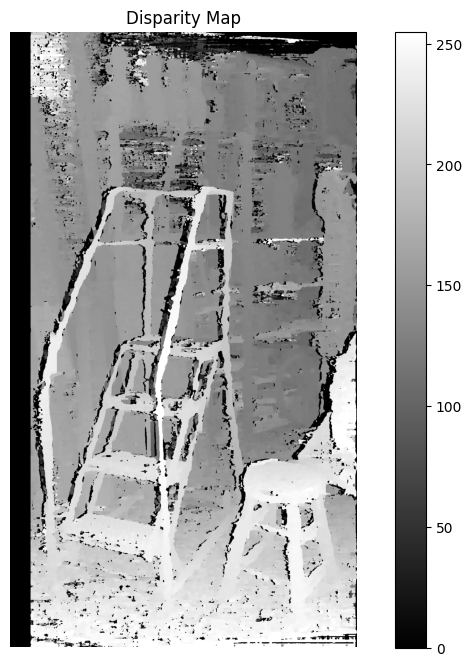

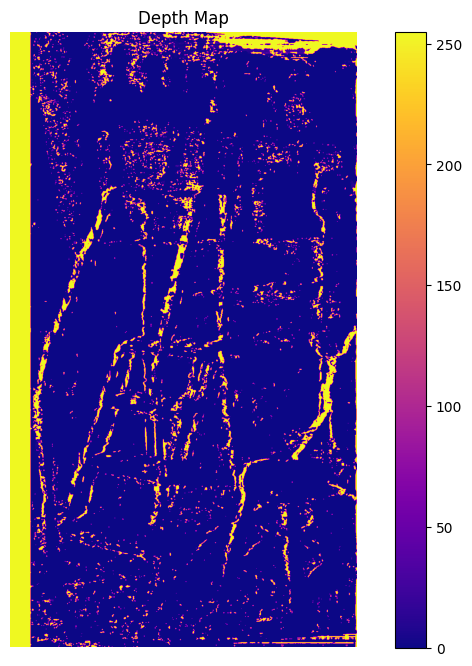

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(img, preprocess_type):
    """Apply preprocessing techniques to the image."""
    if preprocess_type == "Histogram Equalization":
        if len(img.shape) == 3:
            for i in range(3):  # Apply to each channel in RGB
                img[:, :, i] = cv2.equalizeHist(img[:, :, i])
        else:
            img = cv2.equalizeHist(img)
    elif preprocess_type == "Gaussian Blur":
        img = cv2.GaussianBlur(img, (5, 5), 0)
    elif preprocess_type == "Edge Detection":
        img = cv2.Canny(img, 100, 200)
    return img

def compute_depth(disparity_map, baseline, focal_length):
    """Compute depth from disparity map."""
    disparity_map[disparity_map <= 0] = 0.1  # Avoid division by zero
    depth = (baseline * focal_length) / disparity_map
    return depth

def stereo_block_matcher(left_img, right_img, method='BM'):
    """Compute disparity using the selected stereo method."""
    if method == 'BM':  # Block Matching
        stereo = cv2.StereoBM_create(numDisparities=64, blockSize=15)
    elif method == 'SGBM':  # Semi-Global Block Matching
        stereo = cv2.StereoSGBM_create(
            minDisparity=0,
            numDisparities=64,
            blockSize=9,
            P1=8 * 3 * 3**2,
            P2=32 * 3 * 3**2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY,
        )
    else:
        raise ValueError("Unsupported method selected!")

    disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0
    return disparity

def display_map(title, img, cmap='plasma'):
    """Display depth or disparity map using matplotlib."""
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.colorbar()
    plt.axis("off")
    plt.show()


def load_image_from_colab():
    """Allow file upload in Colab."""
    uploaded = files.upload()  # This opens a file dialog in Colab
    for filename in uploaded.keys():
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        return img

def main():
    print("Stereo Depth Estimation Tool")

    # Use file dialogs to load left and right images
    left_img = load_image_from_colab()
    right_img = load_image_from_colab()


    # Preprocessing options
    print("Select preprocessing technique:")
    print("1. Histogram Equalization")
    print("2. Gaussian Blur")
    print("3. Edge Detection")
    print("4. None")
    preprocess_choice = int(input("Enter your choice (1-4): "))
    preprocess_methods = ["Histogram Equalization", "Gaussian Blur", "Edge Detection", None]
    preprocess_method = preprocess_methods[preprocess_choice - 1]

    if preprocess_method:
        left_img = preprocess_image(left_img, preprocess_method)
        right_img = preprocess_image(right_img, preprocess_method)
        print(f"Applied {preprocess_method} to input images.")

    # Get user input for baseline and focal length
    baseline = float(input("Enter baseline distance (in meters): "))
    focal_length = float(input("Enter focal length (in pixels): "))

    # Ask user to choose depth estimation algorithm
    print("Select Depth Estimation Algorithm:")
    print("1. StereoBM")
    print("2. StereoSGBM")
    choice = int(input("Enter your choice (1-2): "))
    if choice == 1:
        algorithm = 'BM'
    elif choice == 2:
        algorithm = 'SGBM'
    else:
        print("Invalid choice. Exiting.")
        return

    if algorithm in ['BM', 'SGBM']:
        print("Computing disparity map using", algorithm, "...")
        disparity = stereo_block_matcher(left_img, right_img, method=algorithm)
        depth_map = compute_depth(disparity, baseline, focal_length)
        disparity_display = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
        display_map("Disparity Map", disparity_display, cmap='gray')

    # Normalize and display depth map
    depth_display = cv2.normalize(depth_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    display_map("Depth Map", depth_display)

if __name__ == "__main__":
    main()
